### Unsupervised clustering results

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set(font_scale=1)
sns.set_style('ticks',{'axes.grid' : False})

figure_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/'

In [2]:
D = pd.read_csv('/home/rohan/Remote-AI/dat/result/TE_NM/gmm_model_select/gmmfits_combined_aT_1_0_aE_1_0_cs_1_0_ad_1_ld_3_ne_1500_ft_500_fiton_zT.csv')
field_name = 'bic_train'
X_mean = D.groupby('n_components').mean()[[field_name]]
X_sd = D.groupby('n_components').std()[[field_name]]
best_n_components = X_mean[field_name].idxmin()

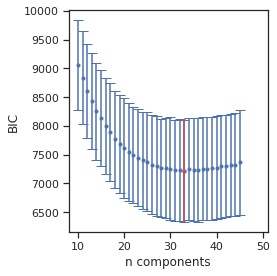

In [3]:
plt.figure(figsize=(4,4))
plt.errorbar(x=X_mean.index.values,
             y=X_mean[field_name].values,
             yerr=X_sd[field_name].values,
             fmt='.',
             capsize=5)

plt.errorbar(x=best_n_components,
             y=X_mean[field_name][best_n_components],
             yerr=X_sd[field_name][best_n_components],
             fmt='.',
             c='r',
             capsize=3)

ax = plt.gca()
ax.set_xlabel('n components')
ax.set_ylabel('BIC')
ax.set_xlim(8,51)
ax.set_xticks(np.arange(10,51,10))
plt.tight_layout()
#plt.savefig(figure_path+'denovo_gmm_bic.png',dpi=300)

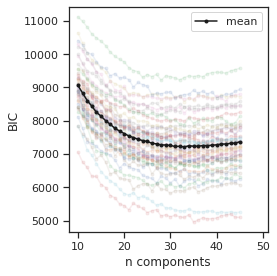

In [4]:
n_component_list=[]
plt.figure(figsize=(4,4))
for cv in range(44):
    Dd = D[D['cv']==cv]
    plt.plot(Dd['n_components'],Dd[field_name],'.-',alpha=0.1)
    temp = Dd.loc[Dd[field_name]==Dd[field_name].min()]
    n_component_list.append(temp['n_components'].values[0])
plt.plot(X_mean.index.values,X_mean[field_name].values,'.-',c='k',label='mean')
ax = plt.gca()
ax.set_xlabel('n components')
ax.set_ylabel('BIC')
#ax.set_ylim(1000,5600)
ax.set_xlim(8,51)
ax.set_xticks(np.arange(10,51,10))
plt.legend()
plt.tight_layout()
plt.savefig(figure_path+'aT_1_0_aE_1_0_cs_1_0_us_bic_cvsets.png',dpi=300)

**Freedman-Diaconis rule** 

bin width $h = 2\times{IQ}\times{n^{−\frac{1}{3}}}$
 - IQ is the interquartile range
 - n is number of observations

In [5]:
from scipy.stats import iqr
FD_binwidth = 2*iqr(n_component_list)*(len(n_component_list))**(-1/3)

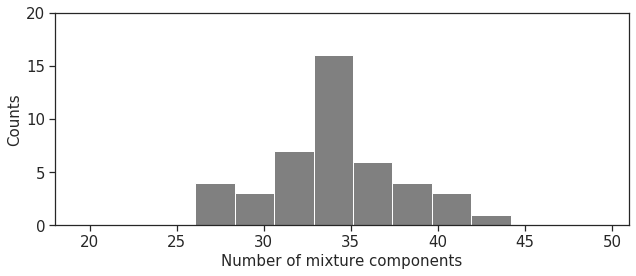

In [8]:
yy = n_component_list
fontsize = 15
plt.figure(figsize=(9,4))
plt.hist(yy,bins=np.arange(16.5,50,FD_binwidth)+0.5,color='gray')
ax = plt.gca()
ax.set_xlabel('Number of mixture components',fontsize=fontsize)
ax.set_ylabel('Counts',fontsize=15)
ax.set_ylim(0,20)
ax.set_xlim(18,51)
ax.set_yticks(np.arange(0,21.5,5))
ax.set_yticklabels(np.arange(0,21.5,5).astype(int),fontsize=fontsize)
ax.set_xticks(np.arange(20,51,5))
ax.set_xticklabels(ax.get_xticks(),fontsize=fontsize)
plt.tight_layout()
plt.savefig(figure_path+'gmm_aT_1_0_aE_1_0_cs_1_0_ad_1_us_bic_hist.png',dpi=300)
plt.show()

### Consensus cluster analysis

In [1]:
# load fitted gmm model from file
import pickle
import numpy as np
import pandas as pd
import scipy.io as sio
from sklearn import mixture
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from copy import deepcopy
from scipy.optimize import linear_sum_assignment
from refactor.utils.tree_helpers import get_merged_ordered_classes
from refactor.utils.plots import contingency,matrix_scatterplot

%matplotlib inline

In [2]:
base_path = '/home/rohan/Remote-AI/'
representation_pth = base_path + 'dat/result/TE_NM_cc/'
gmm_pth            = base_path + 'dat/result/TE_NM_cc/gmm_model_select_cv_0/'
origdata_pth       = base_path + 'dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
figure_pth        = '/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/'

#Get t-types in order as per reference taxonomy:
O = sio.loadmat(origdata_pth,squeeze_me=True)
n_required_classes = np.unique(O['cluster']).size
t_type_labels,t_types = get_merged_ordered_classes(data_labels=O['cluster'].copy(),
                                                   htree_file='./refactor/data/proc/dend_RData_Tree_20181220.csv',
                                                   n_required_classes=n_required_classes)

#well-sampled t-types:
min_sample_thr=10
t_types_well_sampled = []
for t in t_types:
    if np.sum(O['cluster']==t)>min_sample_thr:
        t_types_well_sampled.append(t)

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
aug = 1
fiton='zT'
cv = 0
ri_list = np.arange(0,21,1)

Performed 0 merges. Remaining classes in data = 59


In [3]:
#Load dataset with same test set, trained with different initializations:
XT_orig = O['T_dat']
XE_orig = np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1)
mask_E = np.ones_like(XE_orig)
mask_E[np.isnan(XE_orig)]=0.0
XE_orig[np.isnan(XE_orig)]=0.0

CVdict={}
key_list = ['XrE','XrT','zE','zT','train_ind','val_ind','test_ind']


for ri in tqdm(ri_list):
    cvfold_fname=(f'NM_Edat_pcipfx_aT_{alpha_T:0.1f}_aE_{alpha_E:0.1f}_cs_{lambda_TE:0.1f}'+\
                  f'_ad_{aug:d}_ld_3_bs_200_se_500_ne_1500_cv_{cv:d}_ri_{ri}_500_ft-summary').replace('.','-') + '.mat'
    
    if Path(representation_pth+cvfold_fname).is_file(): 
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[ri] = {key:X[key] for key in key_list}
        CVdict[ri]['Emse'] = np.sum(mask_E*(X['XrE']-XE_orig)**2,axis=1)/np.sum(mask_E,axis=1)
        CVdict[ri]['Tmse'] = np.mean((X['XrT']-XT_orig)**2,axis=1)
        del X
    else:
        print(cvfold_fname,'not found')

100%|██████████| 21/21 [00:04<00:00,  4.21it/s]


**Get cluster labels based on GMM fit applied to zT and zE**

In [4]:
best_n_components = 33
for ri in CVdict.keys():
    fname = (f'gmmfit_restricted_perc_100-0_aT_{alpha_T:.1f}_aE_{alpha_E:.1f}_cs_{lambda_TE:.1f}_'+
            f'ad_1_cv_0_ri_{ri:d}_ld_3_ne_1500_fiton_zT_n_{best_n_components:d}').replace('.','-')+'.pkl'
    with open(gmm_pth+fname, 'rb') as fid:
        gmm = pickle.load(fid)

    #Label predictions using GMM fits:
    CVdict[ri]['ccT_lbl'] = gmm.predict(CVdict[ri]['zT'])
    CVdict[ri]['ccE_lbl'] = gmm.predict(CVdict[ri]['zE'])

In [5]:
#For each clustering, find the best ordering w.r.t. t-type labels:
for cv in CVdict.keys():
    C = contingency(a=t_type_labels.copy()[CVdict[cv]['train_ind']],
                    b=CVdict[cv]['ccT_lbl'][CVdict[cv]['train_ind']],
                    unique_a=t_types,
                    unique_b=np.arange(best_n_components))
    
    #Hungarian algorithm assignments:
    row_ind,col_ind = linear_sum_assignment(-C)
    C_ordered = C[:,col_ind]
    order_y = np.arange(0,best_n_components)[col_ind]

    CVdict[cv]['ccT_lbl_matched'] = CVdict[cv]['ccT_lbl'].copy()
    CVdict[cv]['ccE_lbl_matched'] = CVdict[cv]['ccE_lbl'].copy()

    for i in range(best_n_components):
        ind = CVdict[cv]['ccT_lbl'] == order_y[i]
        CVdict[cv]['ccT_lbl_matched'][ind] = i

        ind = CVdict[cv]['ccE_lbl'] == order_y[i]
        CVdict[cv]['ccE_lbl_matched'][ind] = i

In [6]:
#All the labels are ordered at this point
for cv in CVdict.keys():
    
    #inds = np.concatenate([CVdict[cv]['test_ind'],CVdict[cv]['train_ind']])
    inds = CVdict[cv]['test_ind']
    
    #conservatively remove outliers based on reconstruction errors:
    perc = 95
    Eoutlier_ind = np.flatnonzero(CVdict[cv]['Emse']<np.percentile(CVdict[cv]['Emse'],perc))
    Toutlier_ind = np.flatnonzero(CVdict[cv]['Tmse']<np.percentile(CVdict[cv]['Tmse'],perc))
    TE_keep = np.intersect1d(Eoutlier_ind,Toutlier_ind)
    inds = np.intersect1d(inds,TE_keep)

    #Print mse to select the best 
    print(f'cv: {cv:2d}  '+\
          f'Tmse: {np.mean(CVdict[cv]["Tmse"][inds]):.2f}  '+\
          f'Emse: {np.mean(CVdict[cv]["Emse"][inds]):.2f}  '+\
          f'sum: {np.mean(CVdict[cv]["Tmse"][inds])+np.mean(CVdict[cv]["Emse"][inds]):.3f}')
    
    CVdict[cv]['cc_inds'] = deepcopy(inds)
                                                             
    CVdict[cv]['C_t_type'] = contingency(a=t_type_labels[inds],
                                         b=CVdict[cv]['ccT_lbl_matched'][inds],
                                         unique_a=t_types_well_sampled,
                                         unique_b=np.arange(best_n_components))

    CVdict[cv]['C_consistency'] = contingency(a=CVdict[cv]['ccE_lbl_matched'][inds],
                                              b=CVdict[cv]['ccT_lbl_matched'][inds],
                                              unique_a=np.arange(best_n_components),
                                              unique_b=np.arange(best_n_components))


cv:  0  Tmse: 1.86  Emse: 0.35  sum: 2.209
cv:  1  Tmse: 1.87  Emse: 0.34  sum: 2.206
cv:  2  Tmse: 1.86  Emse: 0.36  sum: 2.218
cv:  3  Tmse: 1.87  Emse: 0.35  sum: 2.222
cv:  4  Tmse: 1.87  Emse: 0.35  sum: 2.215
cv:  5  Tmse: 1.88  Emse: 0.35  sum: 2.235
cv:  6  Tmse: 1.87  Emse: 0.35  sum: 2.217
cv:  7  Tmse: 1.87  Emse: 0.34  sum: 2.207
cv:  8  Tmse: 1.86  Emse: 0.35  sum: 2.217
cv:  9  Tmse: 1.86  Emse: 0.35  sum: 2.207
cv: 10  Tmse: 1.85  Emse: 0.35  sum: 2.206
cv: 11  Tmse: 1.85  Emse: 0.35  sum: 2.201
cv: 12  Tmse: 1.87  Emse: 0.35  sum: 2.220
cv: 13  Tmse: 1.86  Emse: 0.35  sum: 2.213
cv: 14  Tmse: 1.87  Emse: 0.34  sum: 2.206
cv: 15  Tmse: 1.86  Emse: 0.35  sum: 2.214
cv: 16  Tmse: 1.89  Emse: 0.35  sum: 2.233
cv: 17  Tmse: 1.86  Emse: 0.34  sum: 2.202
cv: 18  Tmse: 1.86  Emse: 0.35  sum: 2.213
cv: 19  Tmse: 1.87  Emse: 0.34  sum: 2.214
cv: 20  Tmse: 1.88  Emse: 0.35  sum: 2.229


**Consistency across the modalities, after aligning the unsupervised types with t-types**

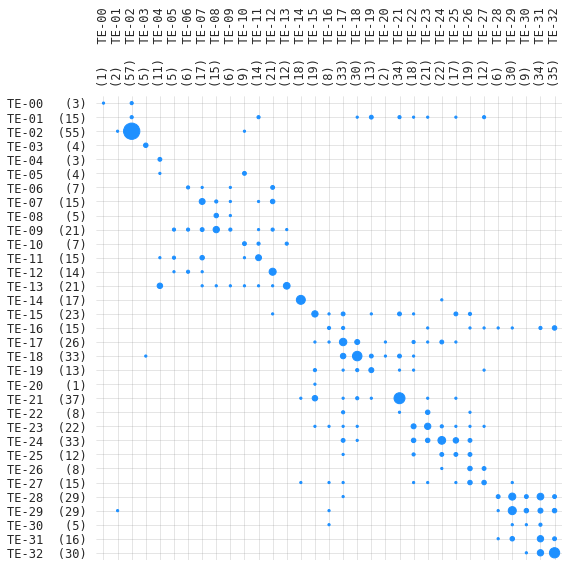

<Figure size 432x288 with 0 Axes>

In [7]:
subset = 'test'

for cv in [11]:    
    xname = [f'TE-{y:02d}' for y in np.arange(best_n_components)]
    xdata = [f'({np.sum(CVdict[cv]["ccT_lbl_matched"][CVdict[cv]["cc_inds"]]==n):d})' for n in np.arange(best_n_components)]
    xlabelc = [f'{b:<6s}'+ f'{a:s}' for (a,b) in zip(xname,xdata)]
    
    yname = [f'TE-{y:02d}' for y in np.arange(best_n_components)]
    ydata = [f'({np.sum(CVdict[cv]["ccE_lbl_matched"][CVdict[cv]["cc_inds"]]==n):d})' for n in np.arange(best_n_components)]
    ylabelc = [f'{a:6s}'+f'{b:>5s}' for (a,b) in zip(yname,ydata)]
    
    matrix_scatterplot(M = CVdict[cv]['C_consistency'],
                       xticklabels = xlabelc, 
                       yticklabels = ylabelc, 
                       xlabel='', 
                       ylabel='', 
                       fig_width=8, 
                       fig_height=8, 
                       scale_factor=5.0)
    
    plt.savefig(f'{figure_pth}TE_{subset}_cv_{cv:d}_zT_n_{best_n_components:d}.png',dpi=300)
    plt.show()

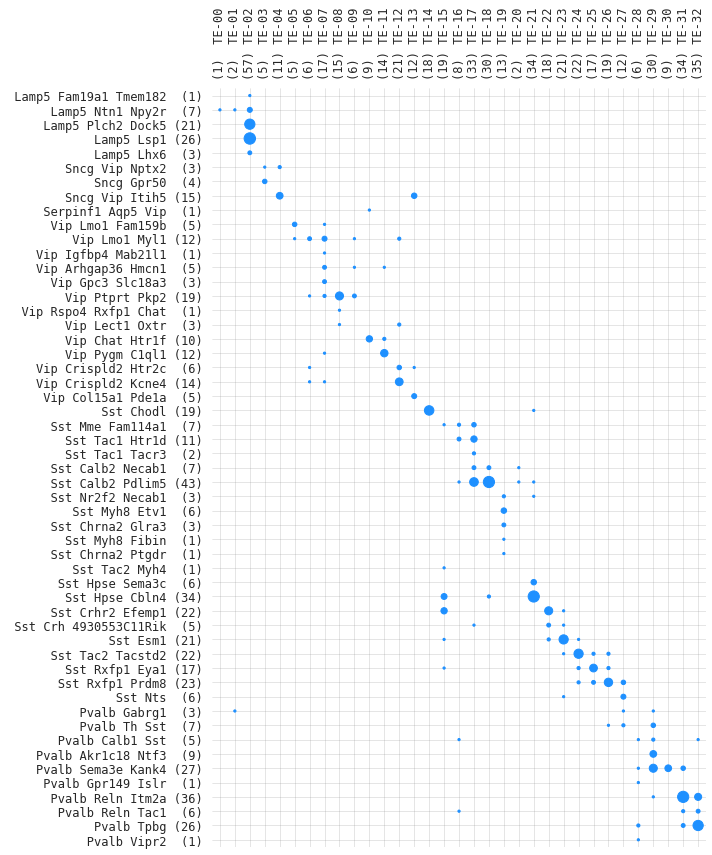

<Figure size 432x288 with 0 Axes>

In [8]:
for cv in [11]:    
    xname = [f'TE-{y:02d}' for y in np.arange(best_n_components)]
    xdata = [f'({np.sum(CVdict[cv]["ccT_lbl_matched"][CVdict[cv]["cc_inds"]]==n):d})' for n in np.arange(best_n_components)]
    xlabelc = [f'{b:<4s}'+ f'{a:>6s}' for (a,b) in zip(xname,xdata)]
    
    yname = [f'{t.rstrip()}' for t in t_types_well_sampled]
    ydata = [f'({np.sum(O["cluster"][CVdict[cv]["cc_inds"]]==t)})' for t in t_types_well_sampled]
    ylabelc = [f'{a:>22s}'+f'{b:>5s}' for (a,b) in zip(yname,ydata)]
    
    matrix_scatterplot(M = CVdict[cv]['C_t_type'],
                       xticklabels = xlabelc, 
                       yticklabels = ylabelc, 
                       xlabel='', 
                       ylabel='', 
                       fig_width=10, 
                       fig_height=12, 
                       scale_factor=5.0)
    
    plt.savefig(f'{figure_pth}TE-t-type_{subset}_cv_{cv:d}_zT_n_{best_n_components:d}.png',dpi=300)
    plt.show()

In [32]:
sio.savemat('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/consensus_cluster.mat',
            {'consensus_cluster':np.array([f'TE-{x:02d}' for x in CVdict[11]['ccT_lbl_matched']]),
            'consensus_cluster_id':CVdict[11]['ccT_lbl_matched']})